In [1]:
from utils import (
    config
)

from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

reload(config)

<module 'utils.config' from 'c:\\Users\\cnbro\\Documents\\1SLA\\Coding\\kanji-practice\\utils\\config.py'>

### Load data

In [2]:
kanji = config.load_all_kanji()
kana = config.load_all_kana()

### Helpers

In [3]:
def parse_morae(msg: str) -> list[str]:
    """
    Given a purely hiragana input, returns a list of morae, each of which consists
    of one or more kana.
    """
    hg_small = kana['hiragana']['small']

    mora_list = []
    mora = ''
    for i, x in enumerate(msg):
        if x in hg_small:
            mora += x
        else:
            if len(mora):
                mora_list.append(mora)
            mora = x
    mora_list.append(mora)
    return mora_list


def get_reading_stem(msg: str) -> str:
    """
    Given a hiragana input potentially with annotations, removes those annotations
    and returns just the pure reading.

    Example: `"ここの.つ"` -> `"ここの"`
    """
    msg = msg.replace('-', '').replace('^', '').replace('!', '')
    idx_dot = msg.find('.')
    if idx_dot != -1:
        msg = msg[:idx_dot]
    return msg

### Parse mora for all kunyomi

In [4]:
reading_col = 'wk_readings_kun'
selected_kanji = kanji[kanji[reading_col].map(lambda x: isinstance(x, list) and len(x) > 0)][['kanji', reading_col, 'jlpt_new']]
all_morae = pd.Series(index=selected_kanji.index, dtype=object)
for i, row in selected_kanji.iterrows():
    readings = row[reading_col]
    these_morae = []
    for reading in readings:
        reading_stem = get_reading_stem(reading)
        reading_morae = parse_morae(reading_stem)
        these_morae.extend(reading_morae)
    all_morae[i] = these_morae
selected_kanji['all_morae'] = all_morae
del all_morae

### Count mora occurrences for each kanji in numpy array

In [5]:
# Get all mora that occur in the dataset
all_possible_morae = set()
for mora_list in selected_kanji['all_morae'].values:
    all_possible_morae |= set(mora_list)
n_possible_morae = len(all_possible_morae)
all_possible_mora_list = list(all_possible_morae)
mora2idx = {m : i for i, m in enumerate(all_possible_mora_list)}
print(f"{n_possible_morae} possible morae")

# Create array of mora occurrences
mora_occurrences = np.zeros((len(selected_kanji), n_possible_morae))
for i, (_, row) in enumerate(selected_kanji.iterrows()):
    for mora in row['all_morae']:
        mora_idx = mora2idx[mora]
        mora_occurrences[i, mora_idx] += 1

71 possible morae


### Create UMAP!

In [6]:
from umap import UMAP
from sklearn.decomposition import PCA

c:\Users\cnbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# PCA
pca_fitter = PCA(
    n_components = 10,
    random_state = 42,
)
pca = pca_fitter.fit_transform(mora_occurrences)

# UMAP
umap_fitter = UMAP(
    n_neighbors          = 15,
    negative_sample_rate = 5,
    min_dist             = 2.0,
    random_state         = 42,
    spread               = 2.0,
)
umap = umap_fitter.fit_transform(pca)

c:\Users\cnbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\cnbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


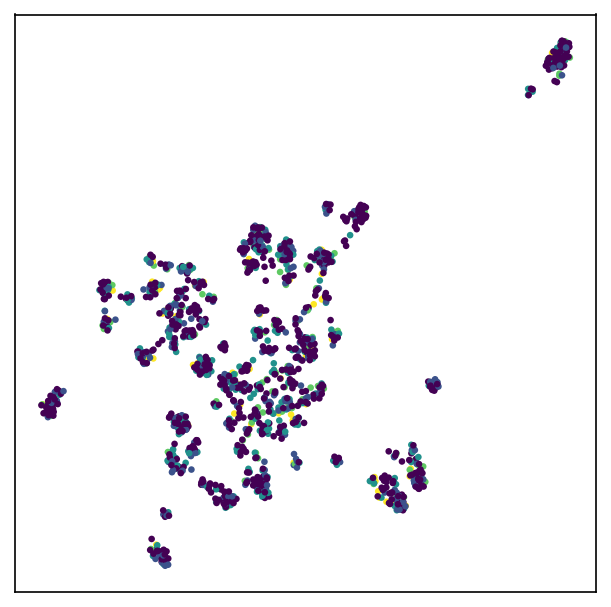

In [8]:
# Standard UMAP projection
plt.close('all')
color = selected_kanji['jlpt_new'] # np.log1p(mora_occurrences.sum(axis=1)) # selected_kanji['jlpt_new']
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150, facecolor='w')
ax.scatter(umap[:, 0], umap[:, 1], c=color, s=10, linewidth=0)
ax.set_xticks([]); ax.set_yticks([]);

(-35.47765060424805, 79.94461151123046)

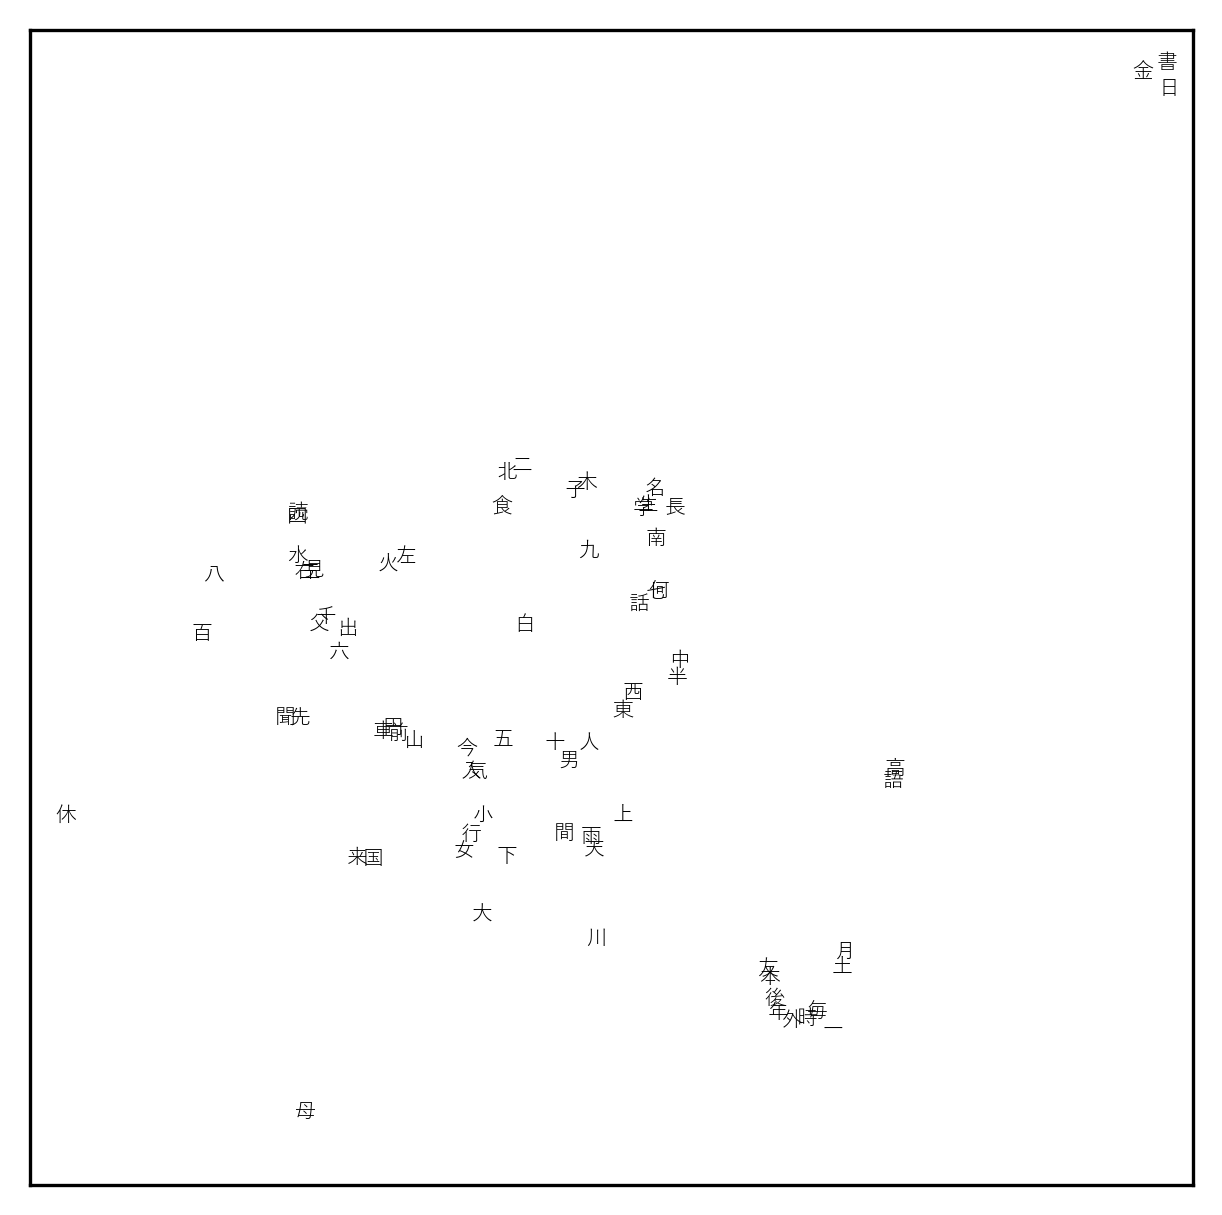

In [9]:
# Actual characters!
plt.close('all')
show_filt = selected_kanji['jlpt_new'].values == 5
xmin, ymin = umap.min(axis=0)
xmax, ymax = umap.max(axis=0)
xrange = xmax - xmin
yrange = ymax - ymin
color = np.log1p(mora_occurrences.sum(axis=1)) # selected_kanji['jlpt_new']
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300, facecolor='w')
for i, (_, row) in enumerate(selected_kanji.iterrows()):
    text = row['kanji']
    coord = umap[i]
    if show_filt[i]:
        ax.text(*coord, text, {"fontfamily": "Yu Gothic", "size": 5})
ax.set_xticks([]); ax.set_yticks([]);
ax.set_xlim(xmin - xrange*0.02, xmax + xrange*0.02)
ax.set_ylim(ymin - yrange*0.02, ymax + yrange*0.02)